# Lesson 2: Light Curves, Quality Flags, and Exoplanets

## Learning Goals: 
- Determine what quality flags mean.
- Explain the potential consequences for ignoring quality flags.
- Decide how to select an appropriate subset of data for analysis based on quality flags.
- List possible non-planetary sources of periodic signals in light curves.

## Lesson Outline:
- [Using example where planet signal is found, unless quality flags are factored in] Generate a lightcurve, phase fold to “find” a planet. 
- Reassess data using quality flags: should we really be using everything? Which flags are going to be problematic for our analysis?
- Appropriately filter the data to return a valid light curve, now without a planet.



<!-- 
In our last lesson, we learned how to plot a light curve in order to search for exoplanets through the transit method. You may have noticed that some of our light curves were noisy or had a "messy" signal, in this lesson we will be learning how to improve the quality of our data and produce better light curves. The process to do this utilizes data quality flags.  -->

## What are data quality flags?

Data quality flags are an indicator in the data that tell the user whether or not the data has been corrected or is deemed poor quality. These flags are put in by the TESS team after making a statistical assessment of the data. We can use these quality flags to throw out bad data and clean up our light curves in order to get a less noisy signal and give us a better chance of finding an exoplanet transit. 

<b>The STScI website provides the following advice on TESS quality flags:<b>

"Not all of these pixels indicate that the data quality is bad. In many cases the flags simply indicate that a correction was made. For instance, bit 7 indicates that a cosmic ray was corrected on one of the pixels in the optimal aperture. If this is the only flag on this cadence, then the data is likely fine and should not be excluded from your analysis. Different science cases may warrant different usages of these flags. As a starting point, the following flags indicate that the cadence will likely be of lesser quality: 1,2,3,4,5,6,8,10,13, and 15. More specifically, a bit-wise AND with the binary number 0101001010111111 indicate cadences that are likely of lesser quality."

### What if we ignore quality flags?
We saw from Lesson 1 that if we plot the data without taking into account any data quality flags, we see very messy signal in certain parts of the light curve. This noise can drown out a possibly faint planetary transit if the "dip" in the light curve from the transit is smaller than the variation of the bad data. Coversely, if we don't remove bad data, we run the risk of misidentifying a noisy signal as a transit.



## Imports
The following cell holds the imported packages. These packages are necessary for running the rest of the cells in this notebook, and you can expect to use some of these packages almost everytime you do astronomical research. A description of each import is as follows:

* `numpy` to handle array mathematics
* `pandas` to handle date conversions
* `fits` from astropy.io for accessing FITS files
* `lightkurve` for normalizing the flux in our light curves
* `Table` from astropy.table for creating tidy tables of the data
* `WCS` from astropy.wcs for storing World Coordinate Systems information 
* `SkyCoord` from astropy.coordinates for defining RA and Dec for targets
* `matplotlib.pyplot` for plotting data and images
* `Mast` and `Observations` from astroquery.mast for querying data and observations from the MAST archive

In [152]:
from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astroquery.mast import Mast, Observations
from astropy.io import ascii
import requests
import lightkurve as lk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

### Choosing a Target
We can examine all the exoplanets discovered by TESS on the MIT TESS Planet Count and Papers [webpage](https://tess.mit.edu/publications/).

The system we will be exploring today is around the star HD 219666. TESS observed this star during Sectors 1 & 28 and discovered the exoplanet HD 219666-b orbiting with a period of 6.03607 days. HD 219666-b has a radius of 4.710 Earth Radii and a mass of 16.60 Earth Masses. 

We can gather the coordinates of HD 219666-b from [TESScut](https://mast.stsci.edu/tesscut/):

RA: 349.5567912422688

DEC: -56.9038988668111

### Query and Download TESS data

In [138]:
ra = 349.5567912422688
dec = -56.9038988668111
coords = SkyCoord(ra,dec,unit='deg')  #make a skycoord object of our coordinates

obs_table = Observations.query_region(coords, radius = "1s")
tess_obs = (obs_table['obs_collection']=='TESS')
observations = obs_table[tess_obs]

In [105]:
#get all data products corresponding to the TESS observations we queried
data_products = Observations.get_product_list(observations)

#filter data products to just retrieve science light curves from TESS
filtered_data_products = Observations.filter_products(data_products,productSubGroupDescription="LC",productType = "SCIENCE",productGroupDescription = "Minimum Recommended Products")
filtered_data_products

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str8,str4,str10,str52,str33,str1,str81,str7,str28,str7,str1,str4,str20,str27,str63,int64,str8,str6,int64
60831405,TESS,timeseries,tess2018206045859-s0001-0000000266980320-0120-s,Light curves,S,mast:TESS/product/tess2018206045859-s0001-0000000266980320-0120-s_lc.fits,SCIENCE,Minimum Recommended Products,LC,--,SPOC,b11c787608,N/A,tess2018206045859-s0001-0000000266980320-0120-s_lc.fits,2039040,60831405,PUBLIC,3
27820886,TESS,timeseries,tess2020212050318-s0028-0000000266980320-0190-s,Light curves,S,mast:TESS/product/tess2020212050318-s0028-0000000266980320-0190-s_lc.fits,SCIENCE,Minimum Recommended Products,LC,--,SPOC,2834068c03,G03278_G03272_G03181_G03106,tess2020212050318-s0028-0000000266980320-0190-s_lc.fits,1848960,27820886,PUBLIC,3


In [106]:
data = Observations.download_products(filtered_data_products)
#Take a peek at the FITS file we downloaded
fits_file = data['Local Path'][0]

In [107]:
fits.info(fits_file)
fits_lc = fits.open(fits_file)

lc = fits_lc[1].data
lc.columns

Filename: ./mastDownload/TESS/tess2018206045859-s0001-0000000266980320-0120-s/tess2018206045859-s0001-0000000266980320-0120-s_lc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  LIGHTCURVE    1 BinTableHDU    167   20076R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        49   (11, 11)   int32   


ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'SAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'PSF_CENTR1'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR1_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'PSF_CENTR2'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR2_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'MOM_CENTR1'; format = 'D'; u

#### Plot raw light curves from data as a check

(1347.0, 1350.0)

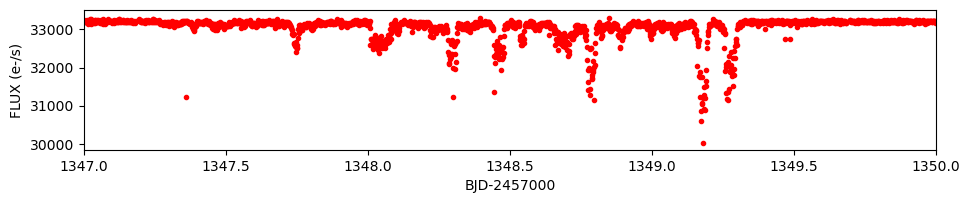

In [190]:
flux = lc['SAP_FLUX'] #SAP flux column
time_lc = lc['TIME'] #time column
quality = lc['QUALITY'] #quality flags column

fig = plt.figure(figsize = (11,4))
fig.add_subplot(211)
plt.plot(time_lc, flux,'.', color = "red")
plt.ylabel("FLUX (e-/s)")
plt.xlabel("BJD-2457000")
plt.xlim(1347,1350) #zoom in

### Phase Folding and Normalizing Flux
"Phase folding" is the process by which we replace the time axis values with the phase of the orbit, which is the same as doing time%period where % is modulo operator which returns the remainder of the quotient **time / period**. We know from the discovery paper of HD 219666-b that it's orbital period is 6.03607 days, so we can use that to calculate the phase. 

"Normalizing" changes the flux from being in units of raw electrons per second to being a fraction of the median flux value. This makes visualizing the flux much easier by displaying the total flux as a value out of 1, without changing anything about the data physically. 

In [179]:
norm_flux = flux/np.nanmedian(flux)

period = 6.03607 #days
phase = time_lc%period 

(2.0, 3.0)

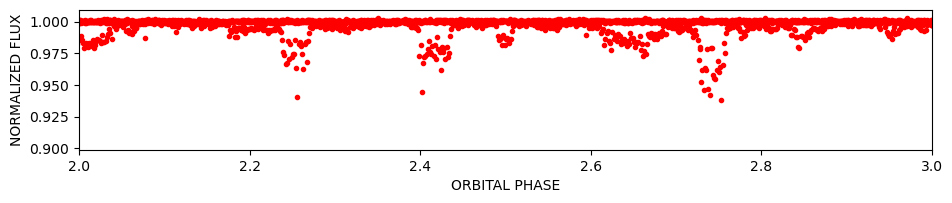

In [183]:
fig = plt.figure(figsize = (11,4))

fig.add_subplot(212)
plt.plot(phase, norm_flux,'.', color = "red")
plt.ylabel("NORMALIZED FLUX")
plt.xlabel('ORBITAL PHASE')
plt.xlim(2,3) #zoom in

At first glance, it might seem like we have some decent dips in our light curve indicating the transit of our exoplanet. However, we need to take into account the data quality flags for this observation. Once we clean up the data, this will provide us with a more accurate light curve and allow us to confirm or reject a transit. 

### Clean up the data
By looking at the columns of the light curve data, we can see there are quality flags for anomolies in the data that we can now remove in order to get the best light curve possible. 

There are several quality flags in place, and you can learn about all of them in the [Archive Manual](https://outerspace.stsci.edu/display/TESS/2.0+-+Data+Product+Overview). For now, we will just be removing data that corresponds to the following flags:

- Bit 1. Attitude Tweak
- Bit 2. Safe Mode
- Bit 3. Coarse Point
- Bit 4. Earth Point
- Bit 5. Argabrightening Event (Sudden brightening across the CCD.)
- Bit 6. Reaction Wheel Desaturation
- Bit 8. Manual Exclude
- Bit 10. Impulsive outlier
- Bit 12. Straylight detected
- Bit 13. Scattered light
- Bit 15. Bad Calibration

In [130]:
bad_bits = np.array([1,2,3,4,5,6,8,10,12,13,15])
value = 0
for v in bad_bits:
    value = value + 2**(v-1)
    
bad_data = np.bitwise_and(quality, value) >= 1 
print(bad_data)

[ True False False ... False False False]


### Re-plot the light curve after removing bad data

(2.0, 3.0)

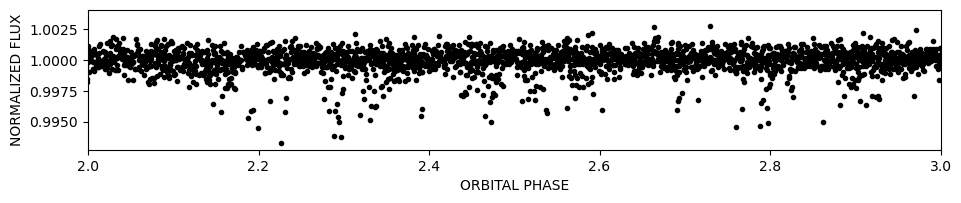

In [185]:
fig = plt.figure(figsize = (11,4))

fig.add_subplot(212)
plt.plot(phase[~bad_data], norm_flux[~bad_data],'.', color = "black") 
plt.ylabel("NORMALIZED FLUX")
plt.xlabel('ORBITAL PHASE')
plt.xlim(2,3) #zoom in

### Over-plot the original light curve with the cleaned light curve to compare

(2.0, 3.0)

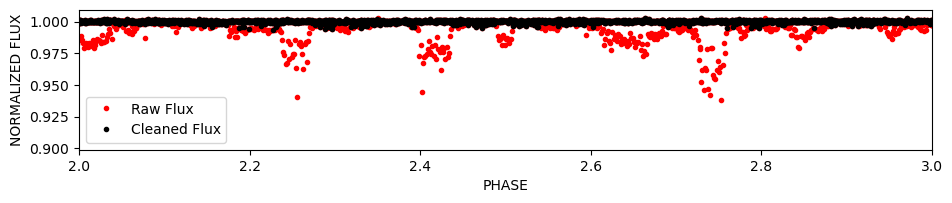

In [187]:
fig = plt.figure(figsize = (11,4))
fig.add_subplot(211)
plt.plot(phase, norm_flux,'.', label = 'Raw Flux', color = "red")
plt.plot(phase[~bad_data], norm_flux[~bad_data],'.', label = 'Cleaned Flux', color = "black")
plt.legend()
plt.ylabel("NORMALIZED FLUX")
plt.xlabel('PHASE')
plt.xlim(2,3) #zoom in

Immediately we can see that what we may have concluded were transits of our exoplanet in our original light curve were actually just bad quality data which got removed when we cleaned up the original light curve. This is a prime example of how important it is to always account for the quality flags of our data when trying to draw conclusions from a visual analysis. 

## Homework

Let's look at how data quality flags affect TESS observations of TRAPPIST-1. This will require you to go back and recall how to query TESS observations of TRAPPIST-1 and retrieve a light curve fits file (HINT: go back to Lesson 1). Now,

(a) Write a Python code snippet that returns the count of observations for each quality flag bit value (0 to 15).

(b) Implement a Python code snippet that calculates the percentage of observations with quality flag bit values of 12 and 13.

(c) Write a Python code snippet that filters the dataset to exclude observations with quality flag bit values of 12 and 13.

## Additional Resources

Here is a link to the paper announcing the discovery of [HD 219666-b](https://ui.adsabs.harvard.edu/abs/2019A%26A...623A.165E/abstract)

You can explore more information about HD 219666 through the [Strasbourg astronomical Data Center (CDS) Portal](http://cdsportal.u-strasbg.fr/?target=HD%20219666)

Here is the link to the [TESS Archive Manual](https://outerspace.stsci.edu/display/TESS/2.0+-+Data+Product+Overview) page all about data quality flags. 

## Acknowledgements

This notebook includes data collected with the TESS mission, obtained from the MAST data archive at the Space Telescope Science Institute (STScI). Funding for the TESS mission is provided by the NASA Explorer Program. STScI is operated by the Association of Universities for Research in Astronomy, Inc., under NASA contract NAS 5–26555.

Any published work that uses Astroquery should include a citation which can be found at [this link](https://github.com/astropy/astroquery/blob/main/astroquery/CITATION) or the BibTeX entry is available from the package itself with: `astroquery.__citation__`

### Notebook Information:
Author: Emma Lieb

Last Updated: 06/20/2023

### STILL TO-DO:
    - add questions throughout